# Prediction of oat yields in Poland based on temperature and precipitation during its growth.
## Introduction
In this notebook we’ve created a Bayesian regression model to predict yields of oat in Poland for a given year, based on monthly average temperatures, and precipitation during the growing season. The point of creating this model is being able to predict the approximate yields before the time of harvest, which can be useful for planning the agricultural economy, such as determining the amount available for sale. Having that information even one month before the harvest could be crucial.

##### Why Oats?
Oats are highly tolerant to difficult growing conditions, making them a valuable crop for changing rainfall patterns and prolonged dry periods, which negatively affect most agricultural crops. In many Polish regions with sandy, gravelly, and low-fertility soils, oats can grow where more demanding crops cannot. Additionally, oats offer significant health benefits compared to other cereals.

Promoting oat cultivation also provides environmental benefits, such as enhancing soil health and structure, reducing soil erosion, and improving crop rotation systems. Oats help maintain soil fertility and break pest and disease cycles, supporting sustainable farming practices.

Given the changing climatic conditions, increasingly irregular rainfall patterns, and long dry periods, oats may become increasingly important in Poland. Kazimierz Noworolnik and Alicja Sułek's work, "Yields of oat cultivars in response to varied soil conditions" emphasizes that oats are resilient to harsh conditions and can be grown on low-fertility soils.

##### Factors Influencing Oat Yields
Yield of oat depends on plenty of factors, such as: oat variety, soil fertility, fertilization, sowing density, agrotechnical treatments, and weather conditions. Weather conditions, especially the amount of precipitation and average temperature during the growing season, are crucial for oat yields. Oats are more drought-tolerant than other cereals, but prolonged water shortages can still lead to significant yield losses. Krystyna Panek's research indicates that precipitation levels are a decisive factor for cereal yields, including oat.

Here's a DAG of the main influences on oat yields:

![SNOWFALL](DAG.png) 

##### Challenges and Limitations of the Model
We are aware that it’s impossible for us to accurately predict yields on a specific field purely based on the weather. That’s why we are considering yields of a whole country to average all of the other factors as much as possible, getting a model for an average farm.

## Data sources
The oat yield data comes from the public GUS data, which contains the yearly average oat yields in Poland ranging only from 2010 (it’s fine, because the most recent technological changes made older data somewhat redundant). It contains oat yields measured by dt/ha (decitons per hectare). This unit is very important because it doesn’t measure the total mass of our yields, but rather the efficiency of the fields (size of the fields doesn’t matter).

The weather data comes from the public IMGW data. We decided to use data from 2013 to 2023. Provided csv files contain monthly precipitation (mm), or monthly average temperature (°C) for each measuring station (precipitation and temperature data came in separate files). Each provided csv file contained data for only one year, which required a lot of preprocessing.

Note: in this project we also used two small, complete datasets, contained in the literature we used for our project. We only used that data for testing priors, because it comes from special experimental fields (belonging to University of Life Sciences in Poznań, and ZD UNG Sadłowice). These fields were kept in perfect conditions during the research, which made the yields far better than of an average field in Poland.


## Data preprocessing
First, we parsed the weather data for each year by averaging precipitation and temperature of all of the measuring stations for each month (since we want to predict yields for the whole country). Then we merged precipitation and temperature data, and discarded all of the irrelevant months, only considering the period of oat growth (from April to July). Finally, we combined all of the chosen years (2013 to 2023), and merged with yearly yield data. The created table was exported to a new csv file.

One more reason we averaged weather data for the whole country, is that we couldn't obtain oat yield data for selected regions.

We merged all of the relevant data to one table for the ease of access.

In [21]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

In [22]:
df = pd.read_csv("oat_data_1.csv")
df = df.drop(["pIV-VII", "tIV-VII"], axis=1)
df.to_csv("oat_data_1_2.csv", index=False)

In [23]:
paths = ["oat_data_1_2.csv", "oat_data_2.csv", "oat_data_3.csv"]
data = []

for path in paths:
    data.append(pd.read_csv(path))

data_labels = ["data from the article[1]", "data for Poland", "oldest data from other article[2]", "all of the data together"]
#data.append(pd.concat(data, ignore_index=True))

data

[   year   pIV    pV    pVI   pVII  tIV    tV   tVI  tVII  yields
 0  1985  21.5  46.8   59.5   24.5  7.5  14.9  14.3  18.0   41.40
 1  1986  32.6  53.3   83.7   56.8  7.4  14.7  16.2  18.0   58.80
 2  1987  28.0  26.0   82.3  111.3  8.0  10.9  15.0  17.1   57.40
 3  1988  28.9  23.3  151.5  103.3  8.0  15.4  16.5  18.7   30.70
 4  1989  25.9   8.8   47.5   75.9  8.7  14.5  16.1  18.4   37.10
 5  1990  49.9  21.8  109.1   45.6  8.0  14.3  16.5  17.0   52.80
 6  1994  47.5  66.4   34.3   63.5  9.1  12.0  15.2  21.9   43.08
 7  1995  12.0  77.6   89.1   16.3  8.2  12.7  16.0  21.0   56.11
 8  1996  13.8  74.2   33.8  216.2  8.3  12.7  16.4  15.8   50.25
 9  1997  39.9  67.6   47.4  177.4  5.5  12.9  17.0  18.0   58.25,
    year        pIV          pV         pVI        pVII        tIV         tV  \
 0  2013  34.756809   99.279384  123.914134   55.178108   7.349045  13.457325   
 1  2014  45.257158  109.534402   66.359402   90.897430   9.035669  12.496815   
 2  2015  31.000926   54.43173

In [24]:
for i in range(3):
    print(data[i].describe())

              year        pIV         pV         pVI        pVII        tIV  \
count    10.000000  10.000000  10.000000   10.000000   10.000000  10.000000   
mean   1990.700000  30.000000  46.580000   73.820000   89.080000   7.870000   
std       4.423423  12.857078  24.970774   37.179917   64.879303   0.973025   
min    1985.000000  12.000000   8.800000   33.800000   16.300000   5.500000   
25%    1987.250000  22.600000  23.975000   47.425000   48.400000   7.625000   
50%    1989.500000  28.450000  50.050000   70.900000   69.700000   8.000000   
75%    1994.750000  38.075000  67.300000   87.750000  109.300000   8.275000   
max    1997.000000  49.900000  77.600000  151.500000  216.200000   9.100000   

              tV        tVI       tVII     yields  
count  10.000000  10.000000  10.000000  10.000000  
mean   13.500000  15.920000  18.390000  48.589000  
std     1.464392   0.828385   1.825407   9.923789  
min    10.900000  14.300000  15.800000  30.700000  
25%    12.700000  15.400000 

# Model 1

Our first model is based on the regression provided in the article "EFFECT OF WEATHER CONDITIONS ON OATS YIELDS" by T. Michalski, R. Idziak, and L. Menzel. The authors came to conclusion that oat yields depend on precipitation in June, and average temperature in May. They came up with the following regression for aproximating the yields:

$$
Y = 41.43 - 0.109\cdot{t_V^2} + 0.764\cdot{O_{VI}} - 0.00433\cdot{O_{VI}^2}
$$

where Y - yields, t - temperature, O - precipitation

We based our model on the regression above, adjusting its parameters. We've decided to use the normal distribution, because we can assume that given the same weather conditions, we can expect similar yields, offset by noise coming from other dependencies we are not considering.

$$Y\sim{Normal(a - b\cdot{t_V^2} + c\cdot{O_{VI}} - d\cdot{O_{VI}^2}, \sigma)}$$
$$a\sim{Normal(\mu_a, \sigma_a)}$$
$$b\sim{Normal(\mu_b, \sigma_b)}$$
$$c\sim{Normal(\mu_c, \sigma_c)}$$
$$d\sim{Normal(\mu_d, \sigma_d)}$$

## Priors

At the start of prior testing we tried to use the parameters given in the article as means of of our model's parameters, to see how do they relate to our data. We tested it on the data from the article, our actual data, and some old data we found in another article of similar topic. As standard deviations of our parameters we used 50% of the mean values, to make our distributions wide enough for fitting.

$$\mu_a = 41.43, \sigma_a = 20.715$$
$$\mu_b = 0.109, \sigma_b = 0.0545$$
$$\mu_c = 0.764, \sigma_c = 0.382$$
$$\mu_d = 0.00433, \sigma_d = 0.002165$$

In [25]:
model_1_prior_1 = CmdStanModel(stan_file='oat_yield_prior_1_1.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


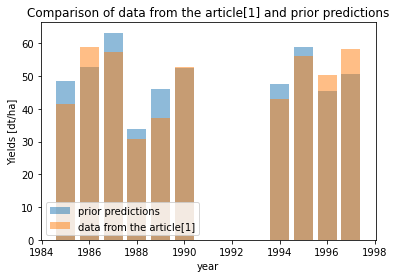

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


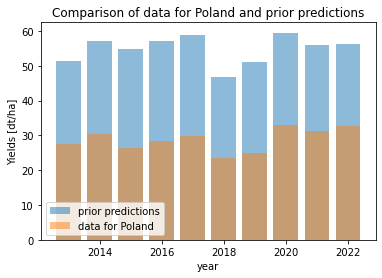

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


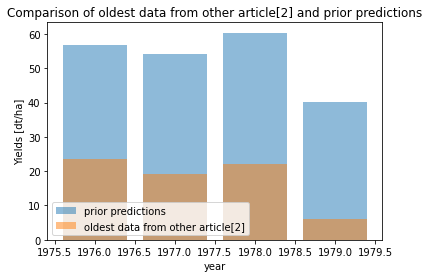

In [26]:
R = 1000
N= []
for i,d in enumerate(data):
    N.append(len(d))
    dict = {
        "N": len(d),
        "precipitation_june": d["pVI"],
        "average_temperature_may": d["tV"]
    }
    sim = model_1_prior_1.sample(
        data=dict,
        iter_sampling=R,
        iter_warmup=1,
        chains=1,
        fixed_param=True,
        seed=42,
        refresh=R
    )

    yields_pred_prior = sim.stan_variable("yields")
    yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)

    plt.bar(list(d["year"]), yields_pred_prior_means, alpha=0.5)
    plt.bar(list(d["year"]), list(d["yields"]), alpha=0.5)
    plt.legend([f"prior predictions", f"{data_labels[i]}"], loc='lower left')
    plt.xlabel('year')
    plt.ylabel('Yields [dt/ha]') 
    plt.title(f'Comparison of {data_labels[i]} and prior predictions') 
    plt.show()

As we can see the prior model predicts the data from the article very well (which is logical, bacause it uses the parameters from the article). It greatly underestimates yields for our data though, which is also logical, because authors of the article kept the plants in perfect conditions, leading to much greater yields than we can expect from an average farm.

We noticed that that the predictions seem to follow our data very well, they are just offset by a large margin. We decided to reduce the value of the intercept (parameter a) to match our data more accurately, keeping other parameters as they are.

The final prior parameters look like this:

$$\mu_a = 16, \sigma_a = 8$$
$$\mu_b = 0.109, \sigma_b = 0.0545$$
$$\mu_c = 0.764, \sigma_c = 0.382$$
$$\mu_d = 0.00433, \sigma_d = 0.002165$$

In [27]:
model_1_prior_1 = CmdStanModel(stan_file='oat_yield_prior_1_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


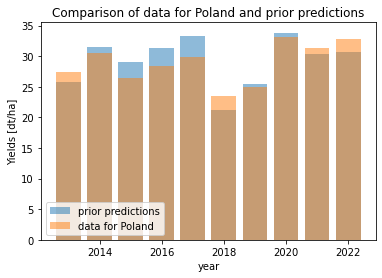

In [28]:
R = 1000
d = data[1]
dict = {
        "N": len(d),
        "precipitation_june": d["pVI"],
        "average_temperature_may": d["tV"]
    }
sim = model_1_prior_1.sample(
    data=dict,
    iter_sampling=R,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=42,
    refresh=R
)

yields_pred_prior = sim.stan_variable("yields")
yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)

plt.bar(list(d["year"]), yields_pred_prior_means, alpha=0.5)
plt.bar(list(d["year"]), list(d["yields"]), alpha=0.5)
plt.legend(["prior predictions", f"{data_labels[1]}"], loc='lower left')
plt.xlabel('year')
plt.ylabel('Yields [dt/ha]') 
plt.title(f'Comparison of {data_labels[1]} and prior predictions') 
plt.show()

The prior predictions turned out to be surprisingly accurate, given we used knowledge worked out in 1999 on modern data averaged for the whole country.

## Posterior

In [29]:
model_posterior = CmdStanModel(stan_file='oat_yield_posterior_1.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████▌| 00:01 Iteration: 1800 / 2000 [ 90%]  (Sampling)



chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.



[-0.78151408  0.00500475  1.84694822  2.15593085  2.45482193 -0.92741445
  0.32394686 -0.32480355 -2.08820376 -2.88987488]


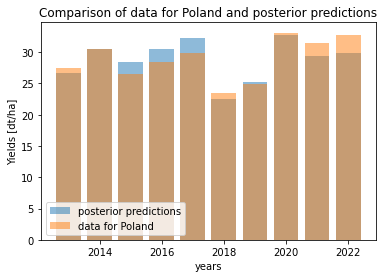

In [30]:
d = data[1]
dict = {
        "N": len(d),
        "precipitation_june": d["pVI"],
        "average_temperature_may": d["tV"],
        "yields": d["yields"]  
    }
fit = model_posterior.sample(data=dict, seed=42)

yields_pred_posterior = fit.stan_variable("yields_pred")
yields_pred_posterior_means = np.mean(yields_pred_posterior, axis=0)

print(yields_pred_posterior_means-list(d["yields"]))
plt.bar(list(d["year"]), yields_pred_posterior_means, alpha=0.5)
plt.bar(list(d["year"]), list(d["yields"]), alpha=0.5)
plt.legend(["posterior predictions", f"{data_labels[1]}"], loc='lower left')
plt.xlabel('years')
plt.ylabel('Yields [dt/ha]') 
plt.title(f'Comparison of {data_labels[1]} and posterior predictions') 
plt.show()

### Parameters



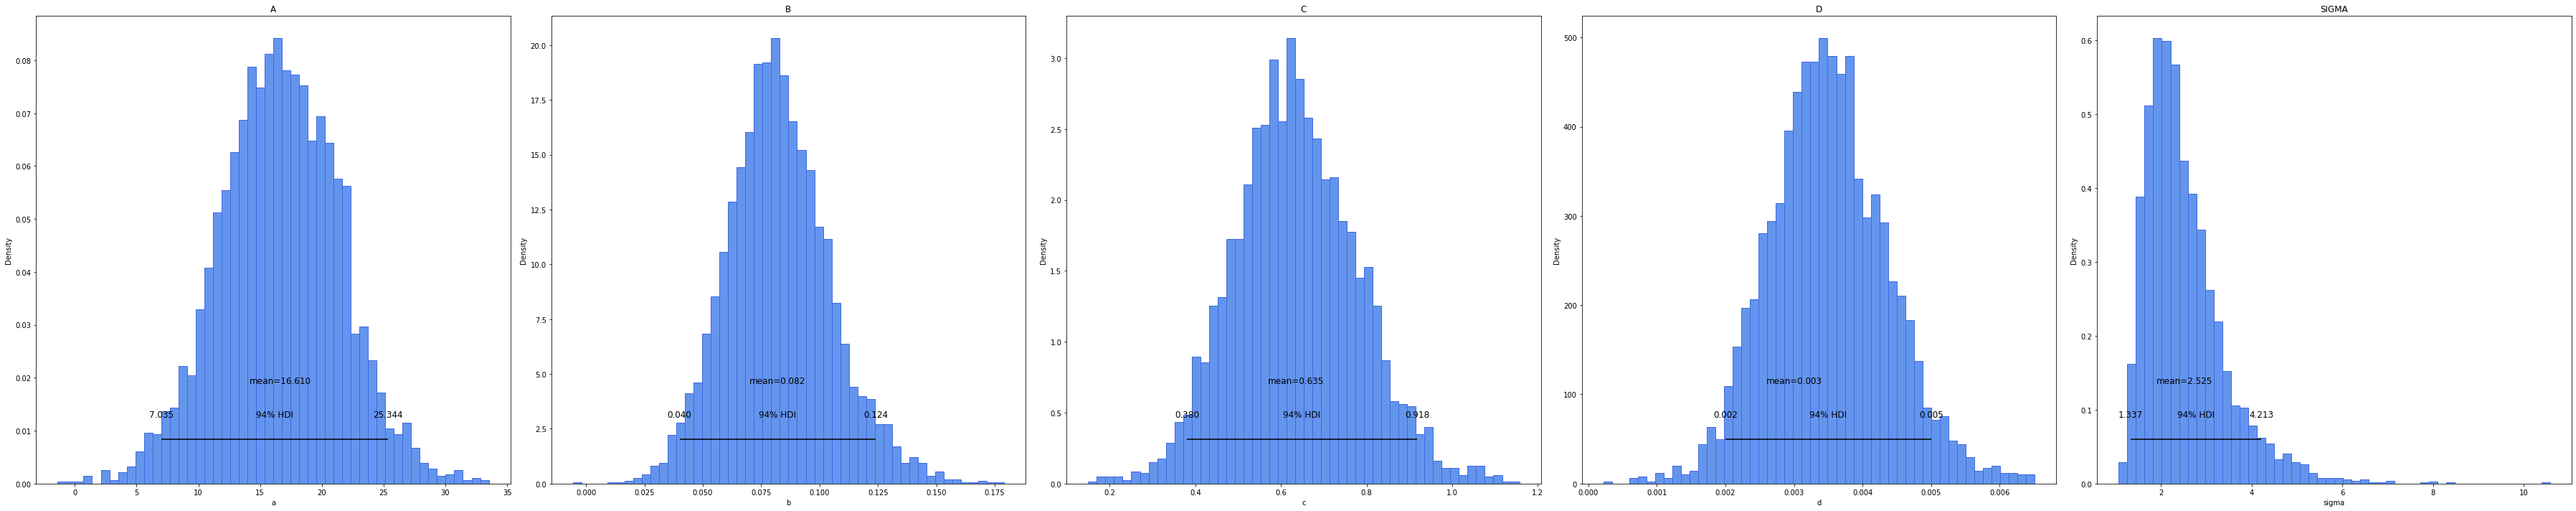

In [31]:
param_names = ['a', 'b', 'c', 'd','sigma']

n_params = len(param_names)
n_rows, n_cols = 1, n_params
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 10*n_rows))


for i, param_name in enumerate(param_names):
    param_values = fit.stan_variable(param_name)

    counts, bins, patches = axes[i].hist(param_values.flatten(), bins=50, color='cornflowerblue', edgecolor='royalblue', density=True)

    statistics = az.summary(fit, var_names=[param_name], kind='stats', hdi_prob=0.94)

    hdi_l = statistics.loc[param_name, 'hdi_3%']
    hdi_h = statistics.loc[param_name, 'hdi_97%']
    mean = statistics.loc[param_name, 'mean']
    
    max_count = max(counts)
    y_hdi = max_count * 0.1
    y_annotate = max_count * 0.15

    # Plot HDI line and annotations
    axes[i].hlines(y=y_hdi, xmin=hdi_l, xmax=hdi_h, color='black')
    axes[i].annotate(f'{hdi_l:.3f}', xy=(hdi_l, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate(f'{hdi_h:.3f}', xy=(hdi_h, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate('94% HDI', xy=((hdi_l + hdi_h) / 2, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate(f'mean={mean:.3f}', xy=(mean, y_annotate * 1.5), xycoords='data', fontsize=12, horizontalalignment='center')
    
    axes[i].set_title(param_name.upper())
    axes[i].set_xlabel(param_name)
    axes[i].set_ylabel('Density')

fig.tight_layout()
plt.show()

There were no problems encountered during sampling.

After fitting process the parameters weren't significantly changed.

The data is very consistent with posterior samples.

# Model 2


After analyzing the initial model, we concluded that it would be a good idea to incorporate precipitation data throughout the whole plant growth period. You could imagine a situation where the temperature in May, and precipitation in June were perfect, but there was no rain (or a flood) in April, May, and July. The model would output a very good yield, but in reality it would definitely be much worse compared to better rain conditions in months we are not considering. This assumption was confirmed by reviewing additional specialized literature. However, due to the lack of correlation information between yields and individual months, we decided to relate yield to the total precipitation during it's growth period.

According to K. Panek in the article "The Effect of Rainfalls on Yielding of Cereals Depending on the Fertilization Level, Soil Cohesion and Cultivation Region," the optimal rainfall for oats is usually around 200-250 mm (April - July period). After analyzing our data, we determined 250 mm as the optimal value. Therefore, we decided to add a new parameter dependent on the total precipitation, which we will multiply by the intercept (parameter a) of the first model's equation, leaving the rest of the formula unchanged.

We concluded that the new parameter 'r' should be based on the t-distribution due to the small sample size and lack of normal distribution values. According to literature, the best value corresponds to a total rainfall of 250 mm, with penalties increasing non-linearly as the value deviates from 250 mm. It is noted that significant rainfall shortages generally have a worse impact than significant excesses.

The new model:

$$Y\sim{Normal(a\cdot{r} - b\cdot{t_V^2} + c\cdot{O_{VI}} - d\cdot{O_{VI}^2}, \sigma)}$$
$$a\sim{Normal(\mu_a, \sigma_a)}$$
$$b\sim{Normal(\mu_b, \sigma_b)}$$
$$c\sim{Normal(\mu_c, \sigma_c)}$$
$$d\sim{Normal(\mu_d, \sigma_d)}$$

For parameter 'r', we use following factors:

$$ \text{deviation} = \text{precipation} - 250$$
$$\nu = 1 + \frac{|\text{deviation}|}{50}$$
$$\text{scale} = \begin{cases} 
    \left(\frac{|\text{deviation}|}{100}\right)^2 & \text{if } \text{deviation} < 0 \\
    \frac{|\text{deviation}|}{200} & \text{if } \text{deviation} \geq 0
\end{cases}$$
$$r_{\text{raw}} \sim \text{Student-t}(\nu, 0, \text{scale})$$
$$r = 1 - |r_{\text{raw}}|$$

where:
- $\text{precipation}$: observed precipitation sum of relevant months
- $\text{deviation}$: deviation from the reference value of 250
- $\nu$: degrees of freedom parameter for Student-t distribution
- $\text{scale}$: scaling factor based on $\text{deviation}$
- $r_{\text{raw}}$: raw value sampled from Student-t distribution
- $r$: transformed value used in the model

## Data preprocessing
Given our previous conclusions, we added an additional column to our data that sums the precipitation for each year separately.

In [32]:
data2 = data

for d in data2:
    d["pIV-VII"] = d[['pIV', 'pV', 'pVI', 'pVII']].sum(axis=1)
data2    

[   year   pIV    pV    pVI   pVII  tIV    tV   tVI  tVII  yields  pIV-VII
 0  1985  21.5  46.8   59.5   24.5  7.5  14.9  14.3  18.0   41.40    152.3
 1  1986  32.6  53.3   83.7   56.8  7.4  14.7  16.2  18.0   58.80    226.4
 2  1987  28.0  26.0   82.3  111.3  8.0  10.9  15.0  17.1   57.40    247.6
 3  1988  28.9  23.3  151.5  103.3  8.0  15.4  16.5  18.7   30.70    307.0
 4  1989  25.9   8.8   47.5   75.9  8.7  14.5  16.1  18.4   37.10    158.1
 5  1990  49.9  21.8  109.1   45.6  8.0  14.3  16.5  17.0   52.80    226.4
 6  1994  47.5  66.4   34.3   63.5  9.1  12.0  15.2  21.9   43.08    211.7
 7  1995  12.0  77.6   89.1   16.3  8.2  12.7  16.0  21.0   56.11    195.0
 8  1996  13.8  74.2   33.8  216.2  8.3  12.7  16.4  15.8   50.25    338.0
 9  1997  39.9  67.6   47.4  177.4  5.5  12.9  17.0  18.0   58.25    332.3,
    year        pIV          pV         pVI        pVII        tIV         tV  \
 0  2013  34.756809   99.279384  123.914134   55.178108   7.349045  13.457325   
 1  2014  45

## Priors
Initially, we adopted the prior values of parameters 'a' through 'd' from the previous model. However, after analyzing the results, we decided to increase the parameter 'a'. In the first model, it roughly represented the average expected yield. In this model, it roughly represents the expected yield for an optimal amount of rainfall, without considering how the rain is spread over the months, or the temperature. The final prior parameters look like this:

$$\mu_a = 24, \sigma_a = 12$$
$$\mu_b = 0.109, \sigma_b = 0.0545$$
$$\mu_c = 0.764, \sigma_c = 0.382$$
$$\mu_d = 0.00433, \sigma_d = 0.002165$$
$$\nu_r= \nu, \mu_r = 0, \sigma_d = scale$$



In [33]:
model_prior2 = CmdStanModel(stan_file='oat_yield_prior_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


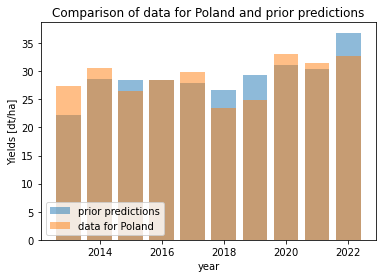

In [34]:
R = 1000
d = data2[1]

dict = {
    "N": len(d),
    "precipitation_june": d["pVI"],
    "average_temperature_may": d["tV"],
    "sum_of_precipation": d["pIV-VII"]
}
sim=model_prior2.sample( data=dict,
                    iter_sampling=R,
                    iter_warmup=1,
                    chains=1,
                    fixed_param=True,
                    seed=42,refresh=R)

yields_pred_prior = sim.stan_variable("yields")
yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)

plt.bar(list(d["year"]), yields_pred_prior_means, alpha=0.5)
plt.bar(list(d["year"]), list(d["yields"]), alpha=0.5)
plt.legend([f"prior predictions", f"{data_labels[1]}"], loc='lower left')
plt.xlabel('year')
plt.ylabel('Yields [dt/ha]') 
plt.title(f'Comparison of {data_labels[1]} and prior predictions') 
plt.show()


As we can see, the prior provides satisfactory results for the contemporary data.

[//]: # "excluding the data from the article 'EFFECT OF WEATHER CONDITIONS ON OATS YIELDS,' ...  and the data from the article on oat irrigation on loose soil"

## Posterior
In order to incorporate the formula used in the prior, besides adding the new parameter 'r' and calculating its coefficients, it was necessary to use the transformed parameters block to convert $r_{\text{raw}}$ to r. However, we did not encounter any issues with subsequent sampling.


In [35]:
model_posterior2 = CmdStanModel(stan_file='oat_yield_posterior_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


Once again, the predictions obtained using the posterior are consistent with the observable actual results. However, for the first model, we noticed the greatest deviations from the expected results for the years 2015-2017. We observed that these years were statistically notable for having extreme conditions in terms of total precipitation (a little over 200 mm in 2015, and over 300 mm in 2016 and 2017). By adding a new parameter that accounts for this dependency, we were able to fit much better to the prevailing conditions

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:03 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:03 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:04 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:04 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:04 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:05 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:05 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:05 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:06 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:06 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:06 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▎  | 00:


INFO:cmdstanpy:CmdStan done processing.



[-0.43756754  0.01873855  0.3200341   0.5214241   0.3101406   0.01874328
  0.25256348  0.2693086  -1.01998852 -0.3153958 ]


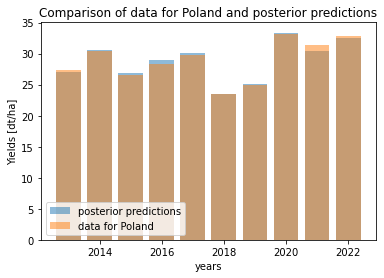

In [36]:
d = data2[1]
dict = {
    "N": len(d),
    "precipitation_june": d["pVI"],
    "average_temperature_may": d["tV"],
    "sum_of_precipation": d["pIV-VII"],
    "yields": d["yields"]
}
fit2 = model_posterior2.sample(data=dict, seed=42)

yields_pred_posterior = fit2.stan_variable("yields_pred")
yields_pred_posterior_means = np.mean(yields_pred_posterior, axis=0)

print(yields_pred_posterior_means-list(d["yields"]))
plt.bar(list(d["year"]), yields_pred_posterior_means, alpha=0.5)
plt.bar(list(d["year"]), list(d["yields"]), alpha=0.5)
plt.legend(["posterior predictions", f"{data_labels[1]}"], loc='lower left')
plt.xlabel('years')
plt.ylabel('Yields [dt/ha]') 
plt.title(f'Comparison of {data_labels[1]} and posterior predictions') 
plt.show()

### Parameters

For this model, we observe that in addition to reducing parameter 'a' and decreasing parameter 'sigma', parameter 'c' has significantly increased, which corresponds to the coefficient indicating the significance of precipitation in June. Thus, we can confirm findings from the literature that, with equal total precipitation across different years, the distribution of this precipitation in June largely determines the yield. From the obtained plots, we also learn that the second model selects parameters with greater confidence and exhibits smaller deviations. However, overall, both models confirm the validity of the formula derived in the literature for conditions across Poland.

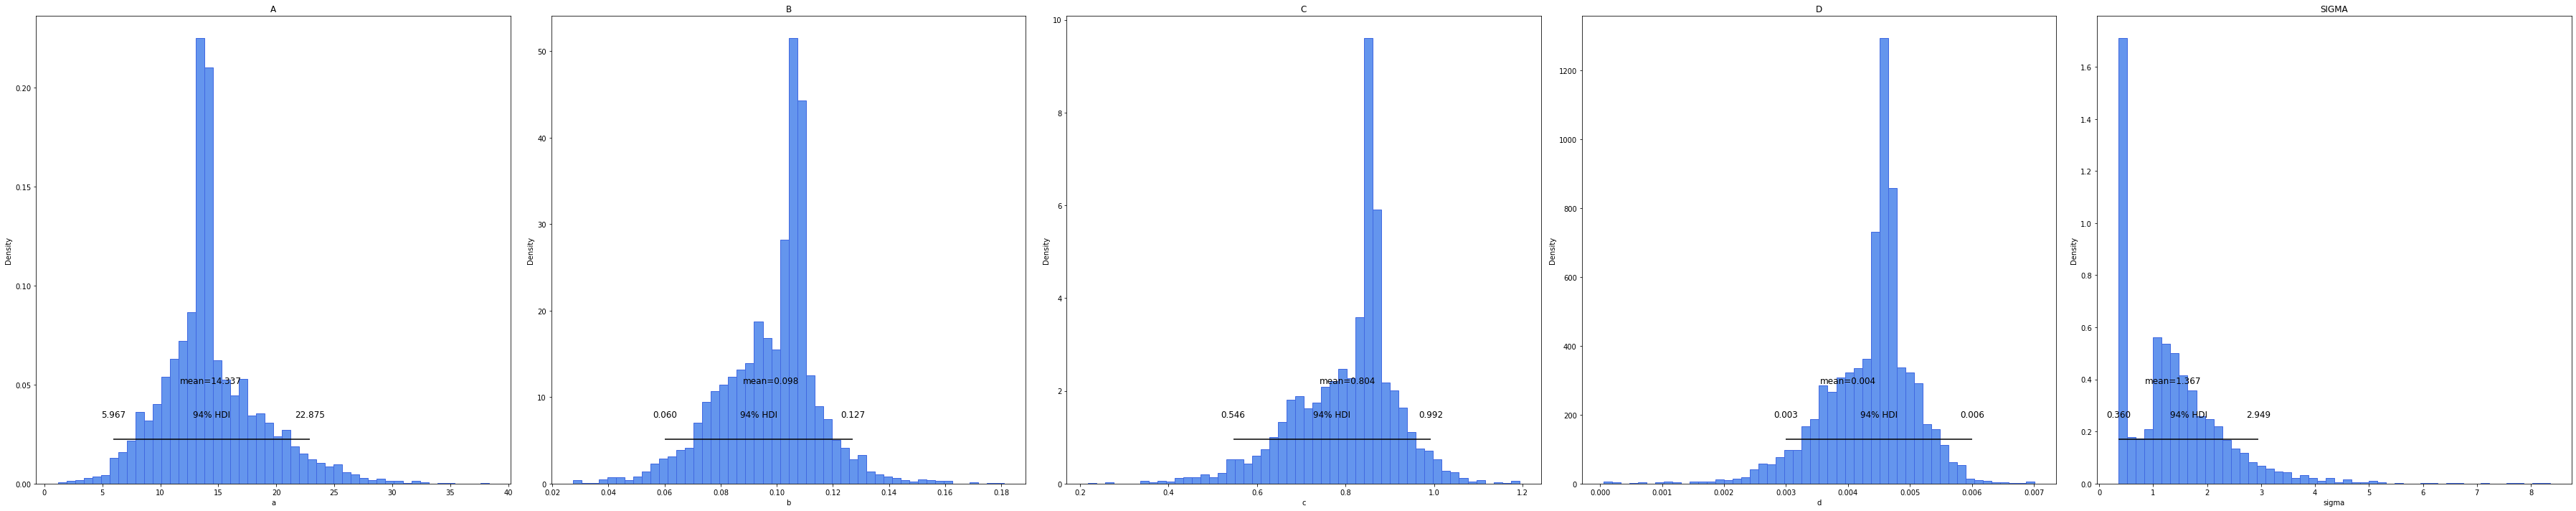

In [37]:
param_names = ['a', 'b', 'c', 'd','sigma']

n_params = len(param_names)
n_rows, n_cols = 1, n_params
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 10*n_rows))


for i, param_name in enumerate(param_names):
    param_values = fit2.stan_variable(param_name)

    counts, bins, patches = axes[i].hist(param_values.flatten(), bins=50, color='cornflowerblue', edgecolor='royalblue', density=True)

    statistics = az.summary(fit2, var_names=[param_name], kind='stats', hdi_prob=0.94)

    hdi_l = statistics.loc[param_name, 'hdi_3%']
    hdi_h = statistics.loc[param_name, 'hdi_97%']
    mean = statistics.loc[param_name, 'mean']
    
    max_count = max(counts)
    y_hdi = max_count * 0.1
    y_annotate = max_count * 0.15

    axes[i].hlines(y=y_hdi, xmin=hdi_l, xmax=hdi_h, color='black')
    axes[i].annotate(f'{hdi_l:.3f}', xy=(hdi_l, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate(f'{hdi_h:.3f}', xy=(hdi_h, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate('94% HDI', xy=((hdi_l + hdi_h) / 2, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate(f'mean={mean:.3f}', xy=(mean, y_annotate * 1.5), xycoords='data', fontsize=12, horizontalalignment='center')
    
    axes[i].set_ylabel('Density')
    axes[i].set_title(param_name.upper())
    axes[i].set_xlabel(param_name)

fig.tight_layout()
plt.show()

For the newly added parameter 'r', we see that it behaves according to our assumptions. The years deviating the most from the average, such as 2015 and 2017, have the lowest values, while the years like 2018 and 2022, where the total precipitation is nearly optimal, receive values close to 1. Once again, for this model, including parameter 'r', we observe a distribution indicating high confidence in the parameter values selected

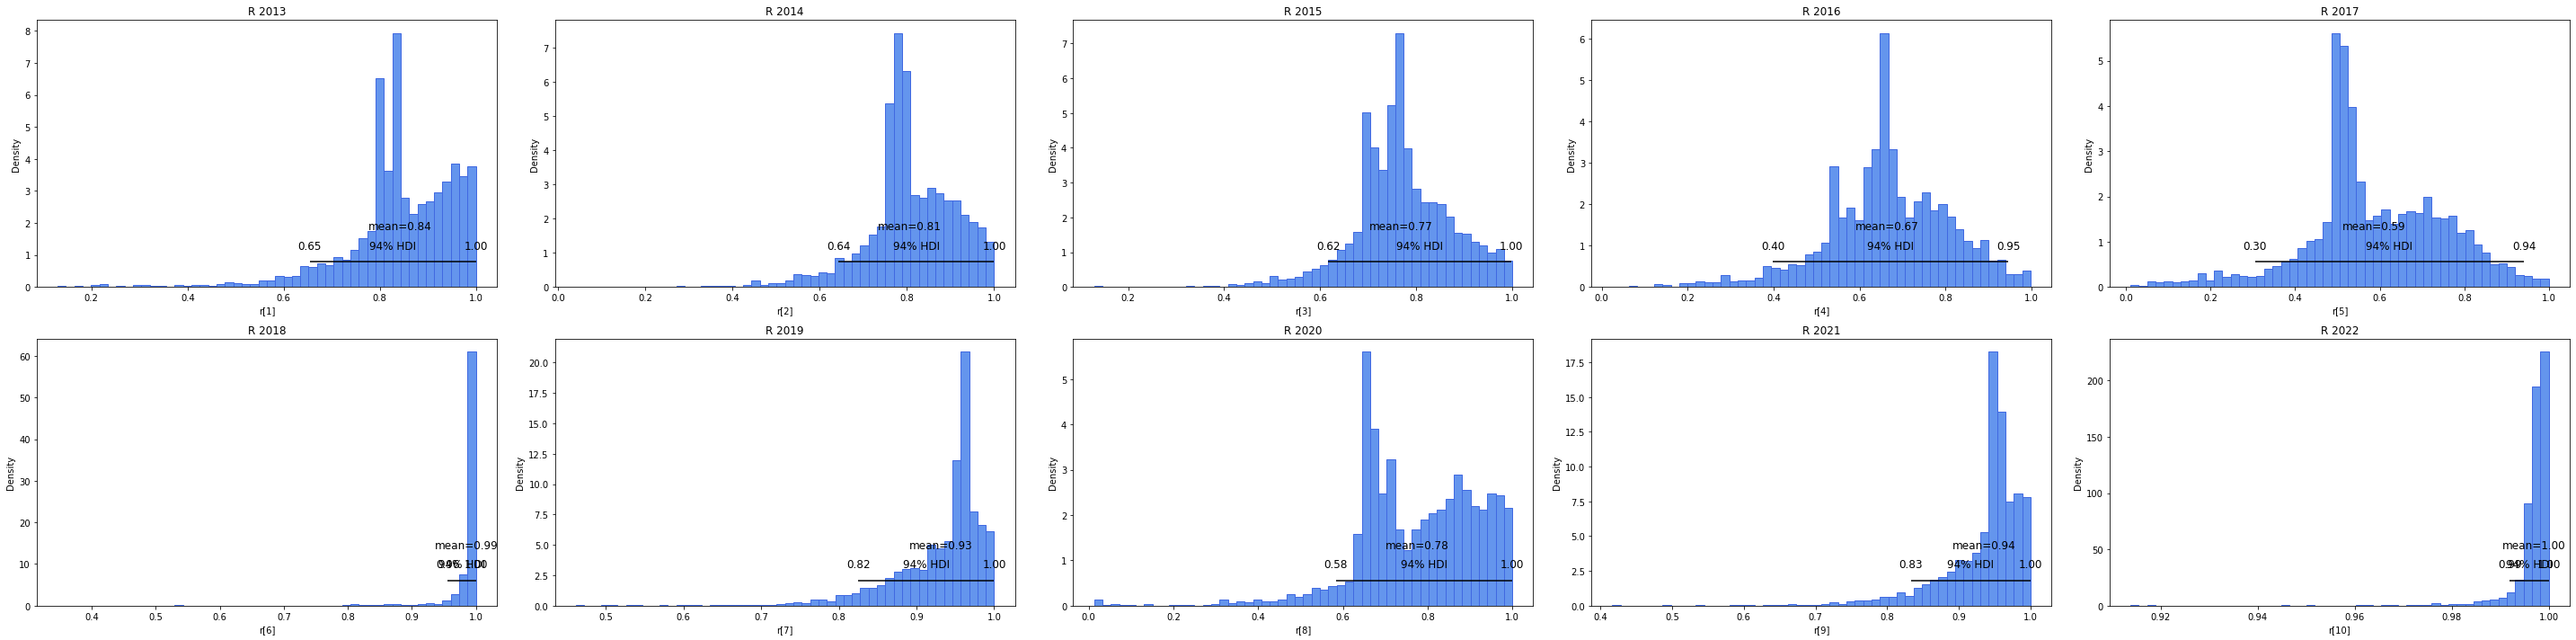

In [38]:
param_name = 'r'
years = list(range(2013, 2023))
param_values = fit2.stan_variable(param_name)
n_elements = 10
n_rows = 2
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

for i in range(n_elements):
    element_values = param_values[:, i]

    counts, bins, patches = axes[i // n_cols, i % n_cols].hist(element_values.flatten(), bins=50, color='cornflowerblue', edgecolor='royalblue', density=True)

    element_name = f'{param_name}[{i}]'
    statistics = az.summary(fit2, var_names=[param_name], kind='stats', hdi_prob=0.94)
    hdi_l = statistics.loc[element_name, 'hdi_3%']
    hdi_h = statistics.loc[element_name, 'hdi_97%']
    mean = statistics.loc[element_name, 'mean']

    max_count = max(counts)
    y_hdi = max_count * 0.1
    y_annotate = max_count * 0.15

    axes[i // n_cols, i % n_cols].hlines(y=y_hdi, xmin=hdi_l, xmax=hdi_h, color='black')
    axes[i // n_cols, i % n_cols].annotate(f'{hdi_l:.2f}', xy=(hdi_l, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i // n_cols, i % n_cols].annotate(f'{hdi_h:.2f}', xy=(hdi_h, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i // n_cols, i % n_cols].annotate('94% HDI', xy=((hdi_l + hdi_h) / 2, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i // n_cols, i % n_cols].annotate(f'mean={mean:.2f}', xy=(mean, y_annotate * 1.5), xycoords='data', fontsize=12, horizontalalignment='center')

    axes[i // n_cols, i % n_cols].set_ylabel('Density')
    axes[i // n_cols, i % n_cols].set_title(f'{param_name.upper()} {years[i]}')
    axes[i // n_cols, i % n_cols].set_xlabel(f'{param_name}[{i+1}]')



fig.tight_layout()
plt.show()

# Model comparison

## PSIS-LOO criterion

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<AxesSubplot:xlabel='Deviance'>

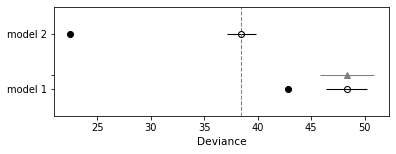

In [39]:
comp_dict = {"model 1":fit, "model 2": fit2}
comp_loo = az.compare(comp_dict, ic="loo",scale="deviance")
az.plot_compare(comp_loo)



## WAIC criterion

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


<AxesSubplot:xlabel='Deviance'>

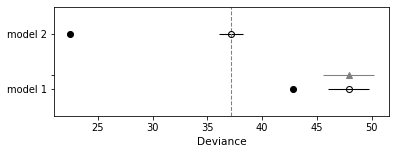

In [40]:
comp_waic = az.compare(comp_dict, ic="waic",scale="deviance")
az.plot_compare(comp_waic)

Both criterions show that the model 2 is a clear winner over the first one. Additional information about the sum of precipitation definitely helped it fit to our data more.

We do agree that model 2 is more accurate, but it's less practical, because it requires more data. Considering that oat harvest already starts at the end of july, we do not have all of the precipitation data needed to make a proper use of it. By the time we obtain all of the data, the model is useless, because we already know our yields, by just harvesting the crop. We can use weather forecasts to work around this issue though, because June's precipitation is not a big factor in the model.

# Literature

[1] T. Michalski, R. Idziak, L. Menzel "WPŁYW WARUNKÓW POGODOWYCH NA PLONOWANIE OWSA" 1999

[2] J. Jankowiak "EFEKTY NAWADNIANIA OWSA NA LUŹNEJ GLEBIE PIASZCZYSTEJ" ZESZYTY PROBLEMOWE POSTĘPÓW NAUK ROLNICZYCH 19B9 z. 377 


[3] K. Noworolnik, A. Sułek "Plonowanie odmian owsa w zależności od warunków glebowych" Polish Journal of Agronomy2017, 31, 16-20


[4] K. Panek "WPŁYW  ILOŚCI  OPADÓW  NA  PLONOWANIE  ZBÓŻ  W  ZALEŻNOŚCI OD  POZIOMU  NAWOŻENIA,  ZWIĘZŁOŚCI  GLEBY  I  REJONU  UPRAWY" ZESZYTY  PROBLEMOWE  POSTĘPÓW  NAUK  ROLNICZYCH  1987  z. 514 